In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [18]:
def encontrar_logo_coca(img, patron='template/pattern.png', meth='cv.TM_CCOEFF_NORMED', sigma_blur=2):

    def escalar(img, escalas=[0.5,1,2]):
        '''
        Devuelve una lista de imagenes reescaladas
        param img: imagen a reescalar
        param escalas: lista de escalas
        '''
        scales = escalas
        resized_imgs = list()
        # generamos nuestras "piramides" de tamaños arbitrarios
        for scale in scales:
            img_resized = img.copy()
            resized_imgs.append(cv.resize(img_resized, None, fx=scale, fy=scale))        
        return resized_imgs
    
    img_rgb    = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray   = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_blured = cv.GaussianBlur(img_gray, ksize=(15,15), sigmaX=sigma_blur, sigmaY=sigma_blur)
    template   = cv.imread(patron,0)
    template   = cv.Canny(template, threshold1=5, threshold2=200)
    img_gray   = cv.Canny(img_gray, threshold1=5, threshold2=200)
    img_blured = cv.Canny(img_blured, threshold1=5, threshold2=200)
    
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    
    # meth = 'cv.TM_CCOEFF'
    method = eval(meth)
    
    # Generamos diferentes escalas del patrón
    # calculo el tamaño máximo del patron escalado para no pasarme de alguna dimensión de la imagen
    max_scale_admitida = np.min([(img.shape[0]/template.shape[0]), (img.shape[1]/template.shape[1])])
    escalas = np.linspace(0.1,max_scale_admitida,20)
    escalas = np.linspace(0.4,max_scale_admitida,20)
    # escalas = [0.5,0.75,1]
    templates_scaladed = escalar(template, escalas)

    min_val_final = 1000000
    max_val_final = -1000000

    for template_scaladed in templates_scaladed:
        
        # Aplicamos la coincidencia de patrones
        #--------------------------------------
        res = cv.matchTemplate(img_blured, template_scaladed, method)
        
        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            if min_val < min_val_final:
                min_val_final = min_val
                top_left = min_loc
                template_final = template_scaladed
                w, h = template_final.shape[::-1]
        else:        
            if max_val > max_val_final:
                max_val_final = max_val
                top_left = max_loc
                template_final = template_scaladed
                w, h = template_final.shape[::-1]
        
        # cv.imshow(str(template_scaladed.shape),template_scaladed)

        
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, (0, 255, 0), 2)
    
    print('Valor Obtenido por el método {} = {}'.format(meth, max_val_final))
    print('Tamaño Imagen: {}'.format(img_gray.shape))
    print('Tamaño Template Orig: {}'.format(template.shape))
    print('Tamaño Template Scaled: {}'.format(template_final.shape))

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure(figsize=(16,16))
    
    # Resultado de coincidencia
    plt.subplot(141),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(142),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(143),plt.imshow(template_final, cmap='gray')
    plt.title('Template Scaled')
    plt.subplot(144),plt.imshow(img_blured, cmap='gray')
    plt.title('Matching Image')

    plt.suptitle(meth)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()


Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.22666707634925842
Tamaño Imagen: (500, 207)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (76, 175)


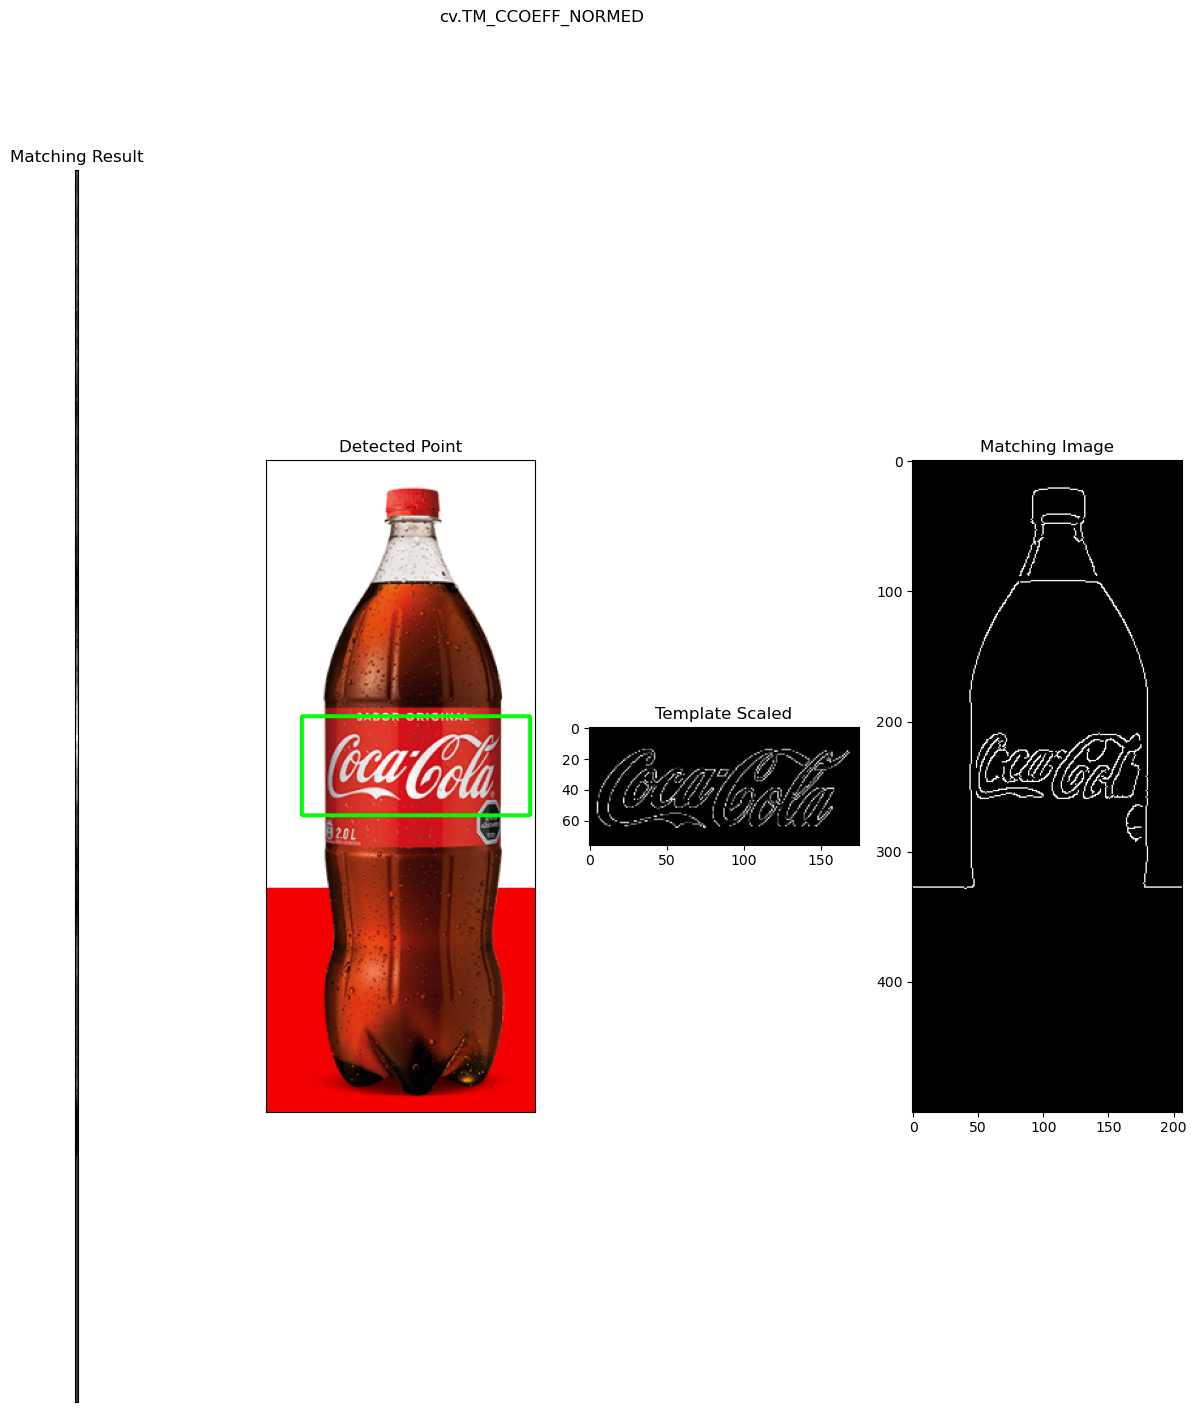

In [19]:
img = cv.imread('images/coca_logo_1.png')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.11389626562595367
Tamaño Imagen: (363, 233)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (97, 221)


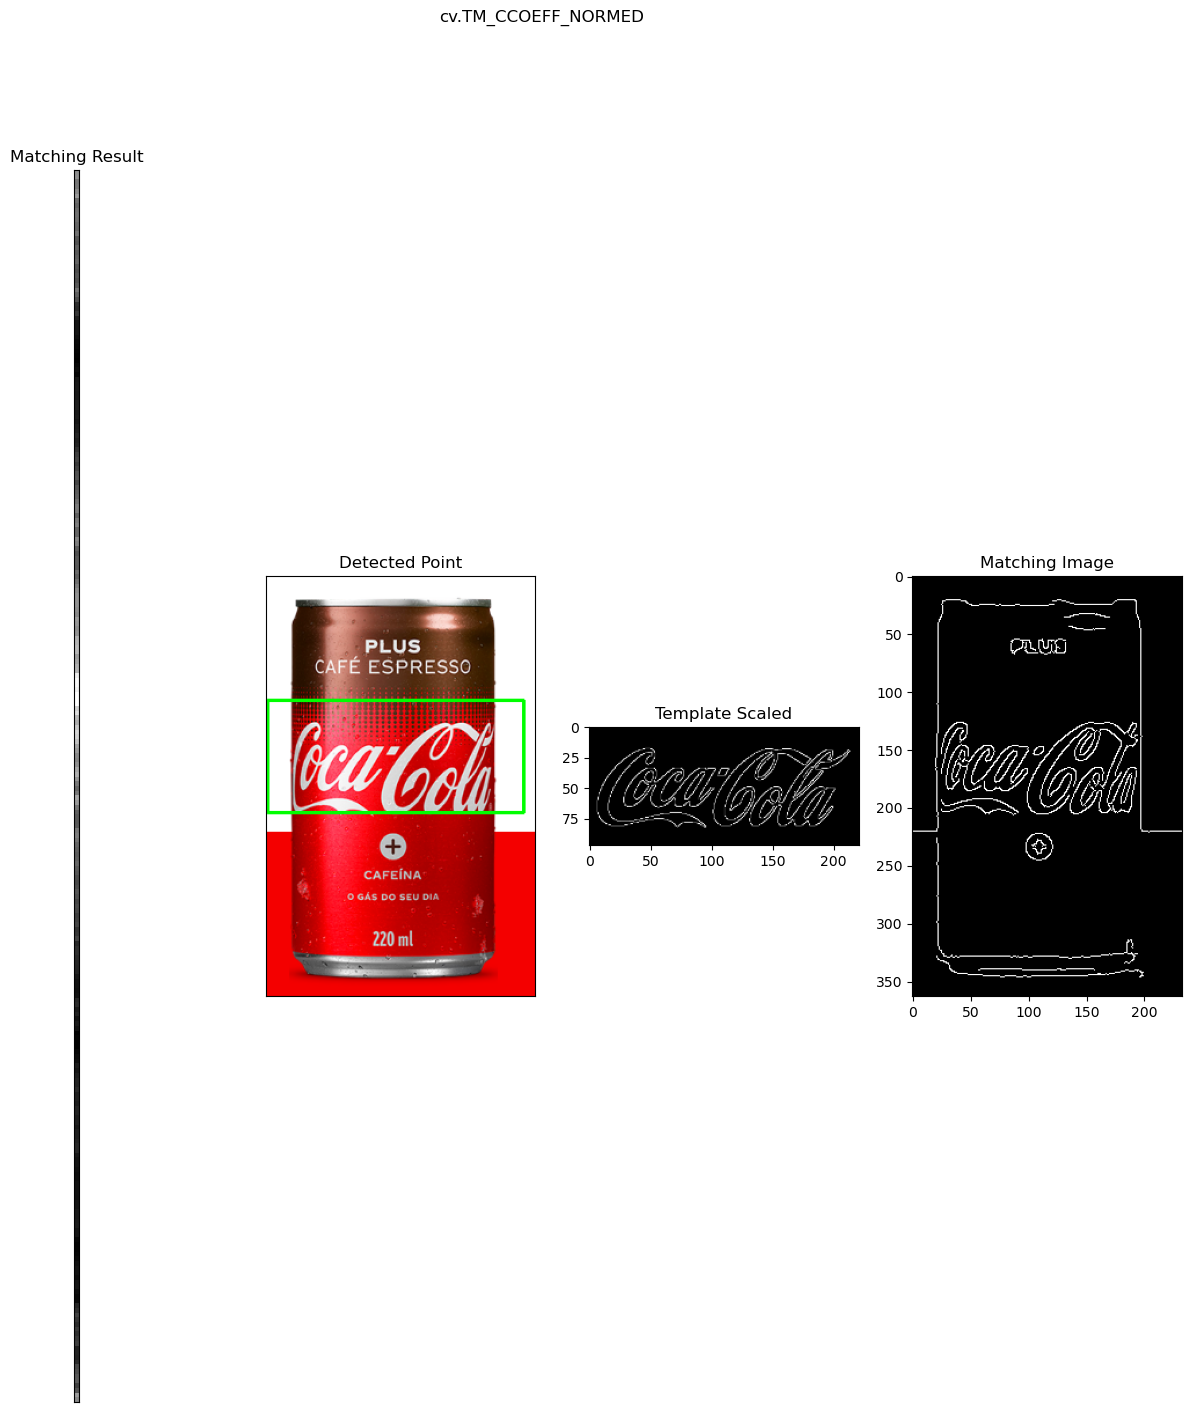

In [31]:
img = cv.imread('images/coca_logo_2.png')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.10861898958683014
Tamaño Imagen: (493, 715)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (236, 540)


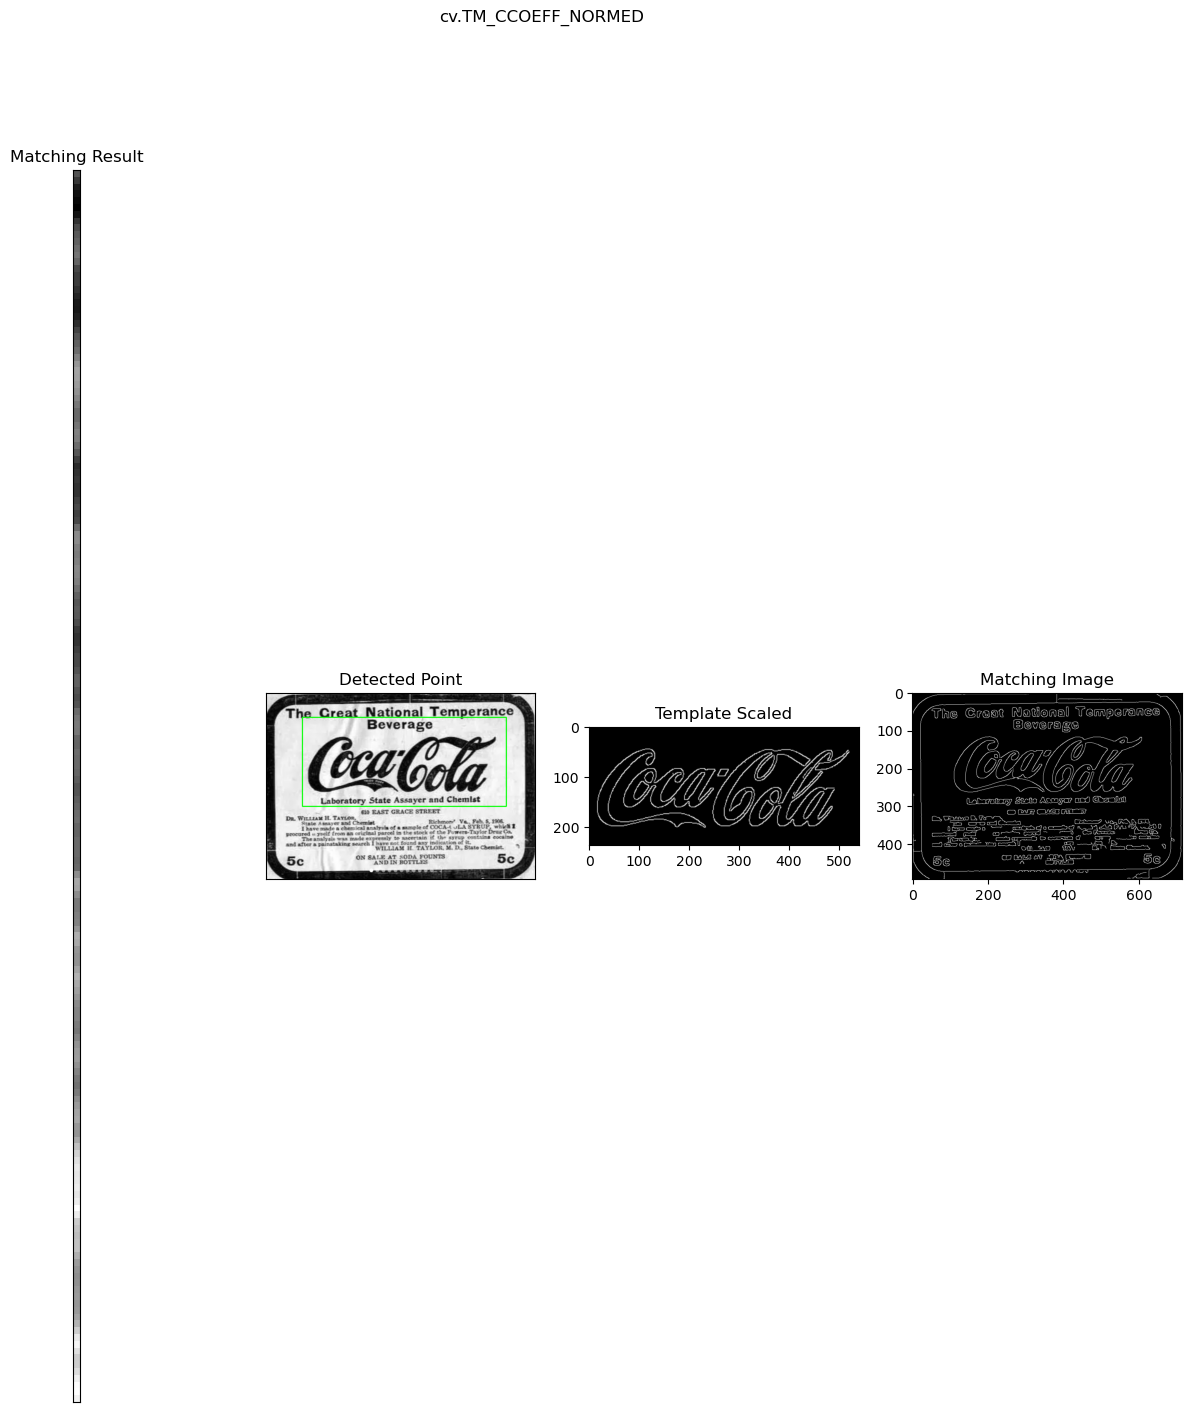

In [32]:
img = cv.imread('images/coca_retro_1.png')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.22870378196239471
Tamaño Imagen: (429, 715)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (70, 160)


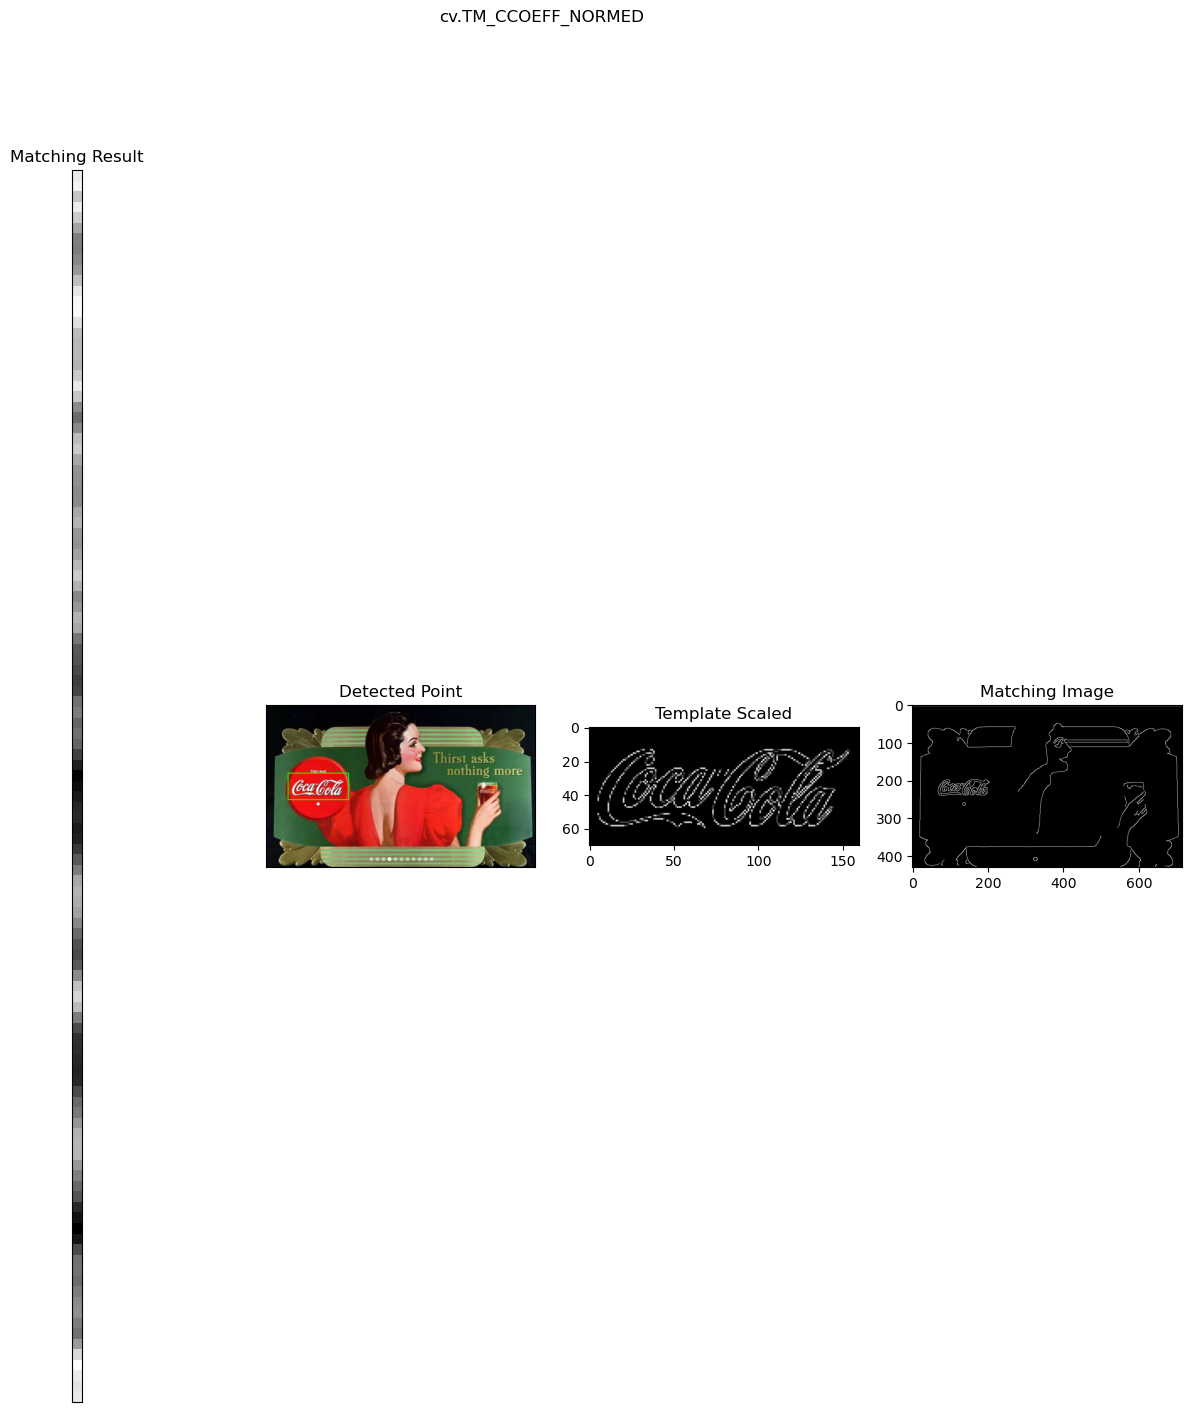

In [33]:
img = cv.imread('images/coca_retro_2.png')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.0958952084183693
Tamaño Imagen: (1389, 1389)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (551, 1260)


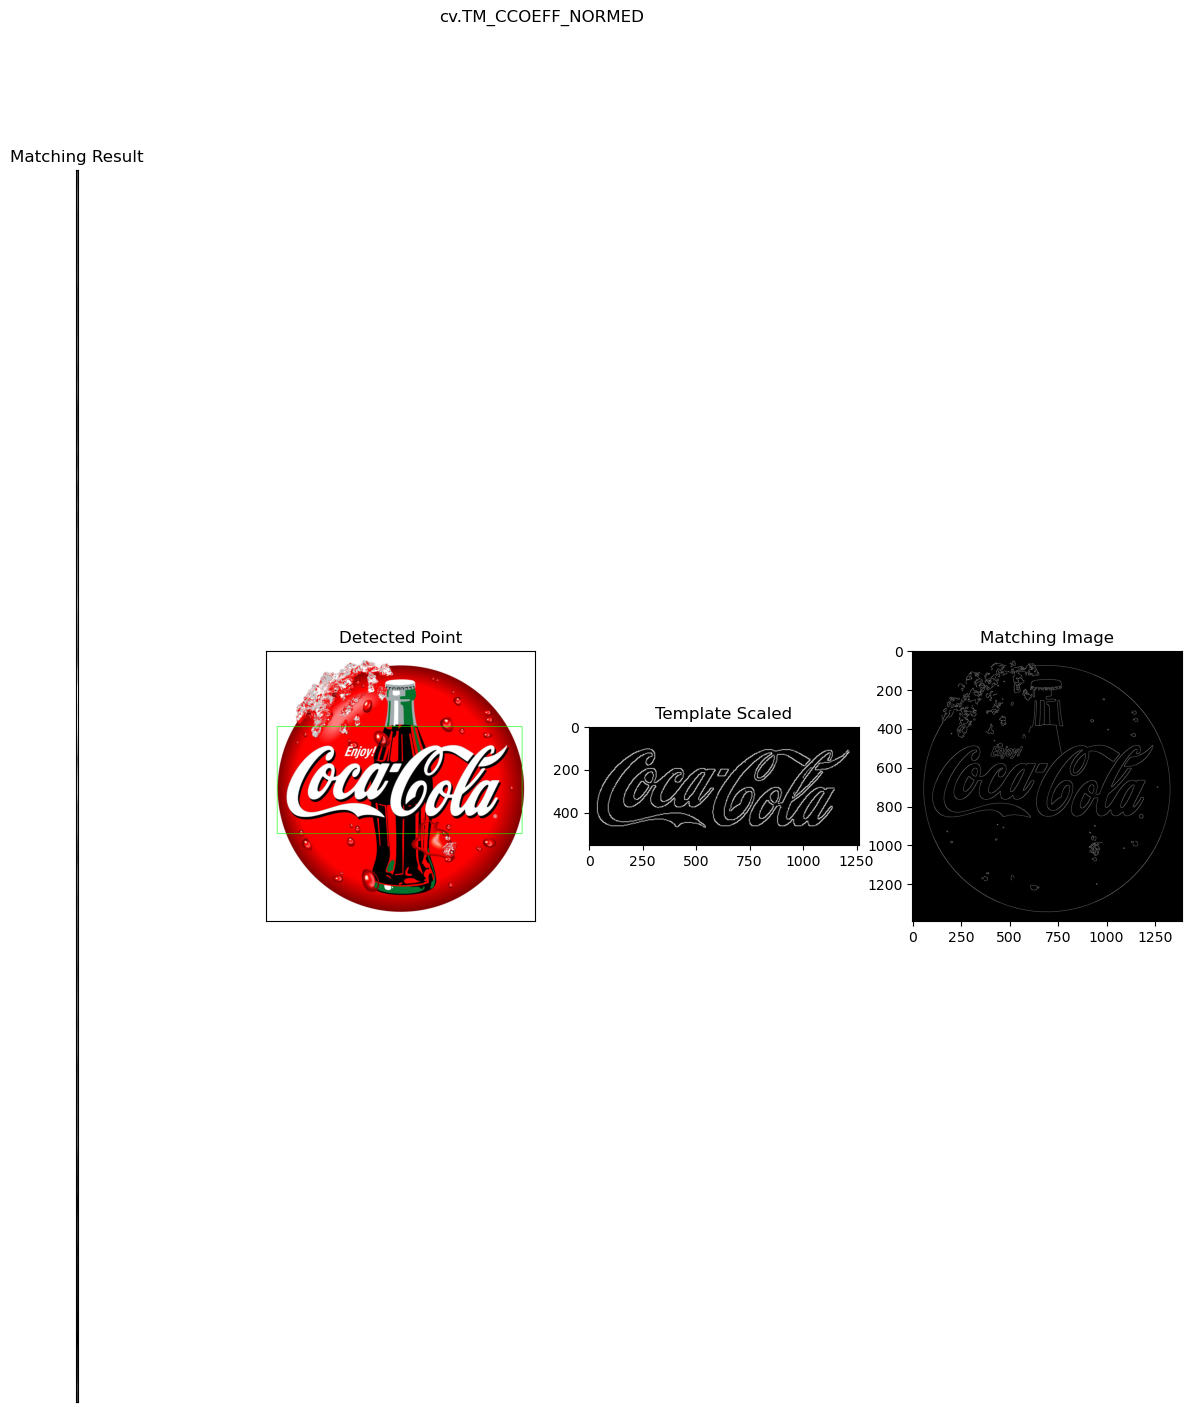

In [34]:
img = cv.imread('images/COCA-COLA-LOGO.jpg')
encontrar_logo_coca(img)

Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.13189250230789185
Tamaño Imagen: (450, 687)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (131, 299)


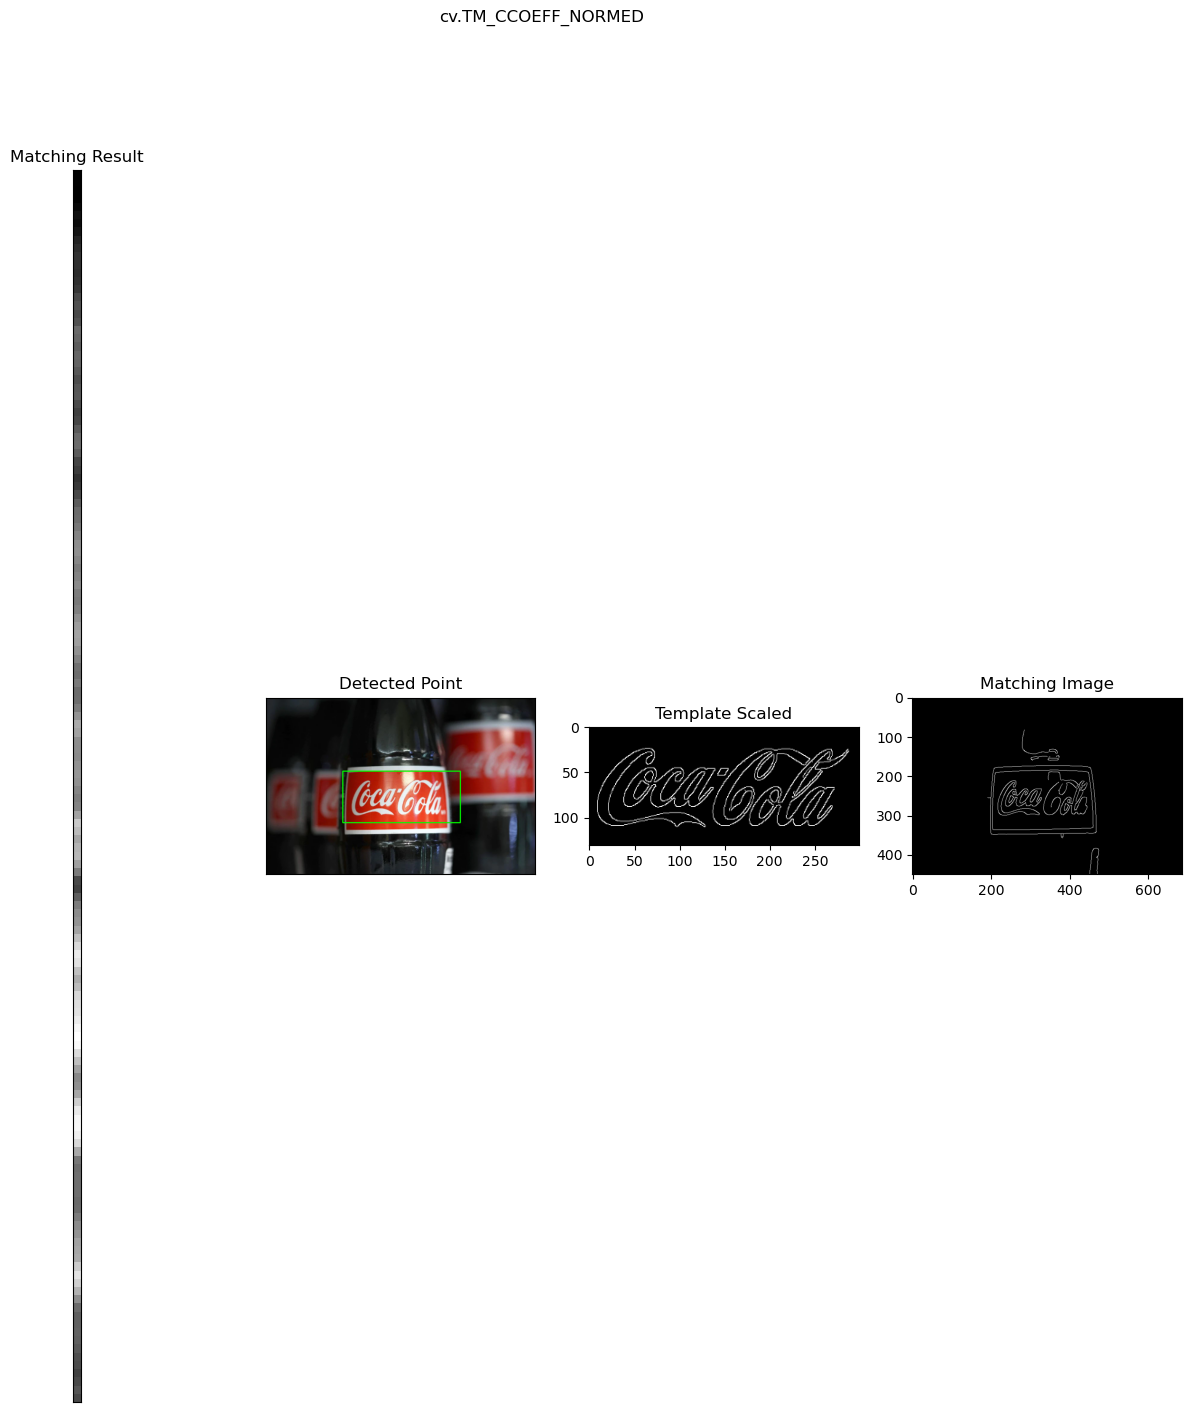

In [37]:
img = cv.imread('images/logo_1.png')
encontrar_logo_coca(img)